**Prerequisits**

In [ ]:
%pip install pandas
%pip install jinja2
%pip install scikit-learn
%pip install seaborn
%pip install matplotlib
%pip install gensim
%pip install gensim
%pip install graphviz
%pip install dtreeviz

**Imports**

In [10]:
import pandas as pd
import numpy as np
import joblib
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt



In [7]:
from sklearn.naive_bayes import MultinomialNB

from sklearn.naive_bayes import BernoulliNB

from sklearn.naive_bayes import GaussianNB

from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier

**Loading and cleaning datasets**

In [11]:
file_path = "dataset\\SQL_Dataset.csv"
df = pd.read_csv(file_path)
df= df.dropna()
df=df.drop_duplicates()
display(df.head().style.map(lambda x: 'font-weight: bold;text-align: left;color: red;'))
display(HTML("<hr>"))
df.info()
display(HTML("<hr>"))
df.describe().style.map(lambda x: 'text-align: center;')

<class 'pandas.core.frame.DataFrame'>
Index: 30907 entries, 0 to 30918
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Query   30907 non-null  object
 1   Label   30907 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 724.4+ KB


**Vectorization function**


In [12]:
def get_doc_embedding(doc, model, vector_size):
    words = doc.split()
    embeddings = [model.wv[word] for word in words if word in model.wv]
    if not embeddings:
        return [0] * vector_size 
    return sum(embeddings) / len(embeddings)


**Splitting dataset**

In [72]:
X = df['Query']
y = df['Label']
vec=1000
tokenized_text = [text.split() for text in X]
cbow_model = Word2Vec(sentences=tokenized_text, vector_size=vec, window=5, min_count=1, workers=4)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# display(HTML("<h2>X_train (Training Data):</h2>"))
# display(X_train.head())
# display(HTML("<hr>"))

# display(HTML("<h2>X_test (Testing Data):</h2>"))
# display(X_test.head())
# display(HTML("<hr>"))

# display(HTML("<h2>y_train (Training Labels):</h2>"))
# display(y_train.head())
# display(HTML("<hr>"))

# display(HTML("<h2>y_test (Testing Labels):</h2>"))
# display(y_test.head())
# display(HTML("<hr>"))


In [73]:
X_train =  [get_doc_embedding(doc, cbow_model, vec) for doc in X_train]
X_test = [get_doc_embedding(doc, cbow_model, vec) for doc in X_test]
X_train = pd.DataFrame(X_train).to_numpy()
X_test = pd.DataFrame(X_test).to_numpy()

In [64]:
scaler = MinMaxScaler()
X_train_1 = scaler.fit_transform(X_train)
X_test_1 = scaler.transform(X_test)

In [74]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print(X_train[:5])
print(X_train[5:10])

[[ 3.38205308e-01 -2.29025379e-01  1.12346791e-01 ...  6.28825575e-02
  -2.07586676e-01 -1.63604945e-01]
 [ 1.34400755e-01 -9.25057828e-02  2.19106372e-03 ...  5.80509019e-04
  -2.10890044e-02 -1.64733797e-01]
 [ 4.90851849e-01  3.08759529e-02  2.84265608e-01 ... -3.07562500e-01
   1.05963223e-01 -1.23777173e-01]
 [ 1.53550833e-01 -2.77915180e-01  2.01890782e-01 ...  1.27318069e-01
  -1.94058448e-01  5.68457432e-02]
 [ 7.30642059e-05  1.57996779e-04  2.51243124e-04 ...  4.33202746e-04
   5.26932708e-04 -6.67621265e-04]]
[[ 5.19084334e-01  3.91434908e-01  3.39204103e-01 ... -2.89680302e-01
   3.88938218e-01 -1.59267068e-01]
 [ 4.57363933e-01  1.40039369e-01  2.82069296e-01 ... -3.94796640e-01
   2.06066474e-01 -1.30635872e-01]
 [ 4.37936008e-01 -1.42135501e-01  3.26096088e-01 ... -4.91710380e-02
  -6.85424656e-02  3.26579697e-02]
 [-9.30115348e-04 -9.73738905e-04 -7.71589985e-04 ... -4.91120445e-04
   1.80011033e-04 -2.01733463e-04]
 [ 4.46815163e-01  6.34906441e-02  7.23262727e-02 ... 

In [46]:
joblib.dump(cbow_model,"models//cbow_model")


['models//cbow_model']

**Evaluation function**

In [14]:
def eval(model,matrix,x_test):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    y_prob = model.predict_proba(x_test)

    for i in range(len(model.classes_)):
        fpr[i], tpr[i], _ = roc_curve((y_test == model.classes_[i]).astype(int), y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure(figsize=(8, 6))

    for i in range(len(model.classes_)):
        plt.plot(fpr[i], tpr[i], label=f'{model.classes_[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

In [37]:
def eval_keras(model, matrix, x_test, y_test):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    y_prob = model.predict(x_test)

    

    y_prob = model.predict(x_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_prob)

    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    model.summary()

    

# Supervised Learning

## Multinomial Naïve Bayes

In [9]:
mnb_model = MultinomialNB()
mnb_model.fit( X_train_1, y_train)
joblib.dump(mnb_model, 'models/mnb_model.joblib')

y_pred = mnb_model.predict( X_test_1)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy}")
display(HTML("<hr>"))

print("Confusion Matrix:")
print(conf_matrix)
display(HTML("<hr>"))

print("Classification Report:")
print(classification_rep)
display(HTML("<hr>Model saved"))

#Accuracy: 0.982368165642187


Accuracy: 0.982368165642187


Confusion Matrix:
[[3867   45]
 [  64 2206]]


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3912
           1       0.98      0.97      0.98      2270

    accuracy                           0.98      6182
   macro avg       0.98      0.98      0.98      6182
weighted avg       0.98      0.98      0.98      6182



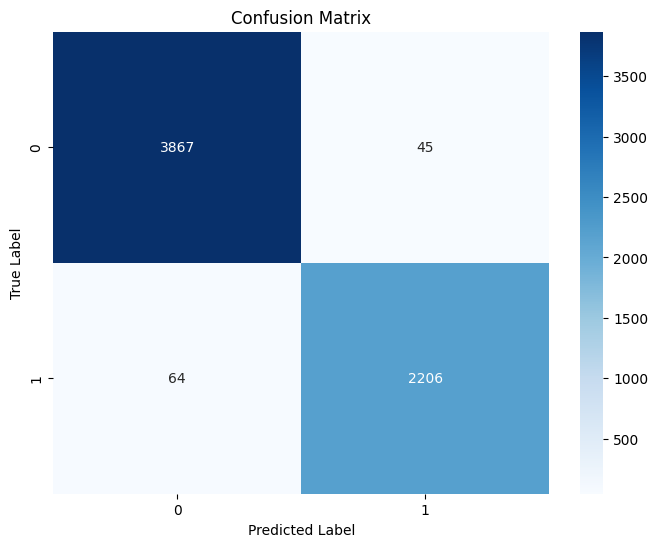

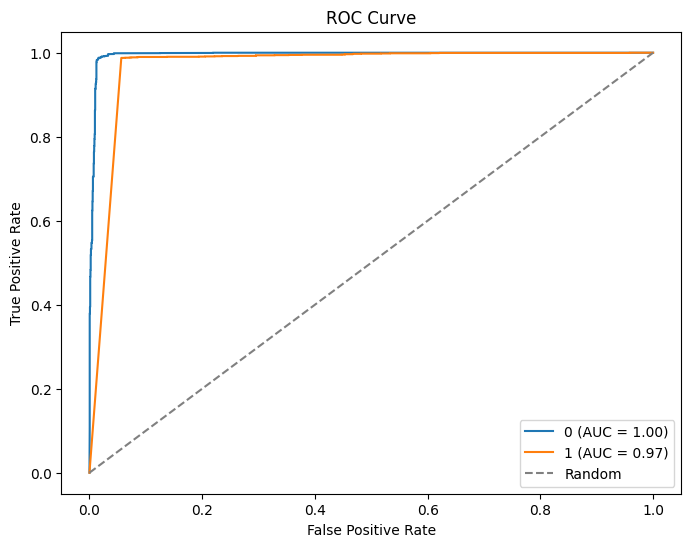

In [10]:
eval(mnb_model,conf_matrix,X_test)

## Bernoulli’s Naïve Bayes

In [11]:
bnb_model = BernoulliNB()

bnb_model.fit(X_train, y_train)
y_pred  = bnb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred )
conf_matrix  = confusion_matrix(y_test, y_pred )
classification_rep  = classification_report(y_test, y_pred )
joblib.dump(bnb_model , 'models/bnb_model.joblib')

print(f"Accuracy: {accuracy }")
display(HTML("<hr>"))

print("Confusion Matrix:")
print(conf_matrix )
display(HTML("<hr>"))

print("Classification Report:")
print(classification_rep )
display(HTML("<hr>Model saved"))

Accuracy: 0.9792947266256875


Confusion Matrix:
[[3828   84]
 [  44 2226]]


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3912
           1       0.96      0.98      0.97      2270

    accuracy                           0.98      6182
   macro avg       0.98      0.98      0.98      6182
weighted avg       0.98      0.98      0.98      6182



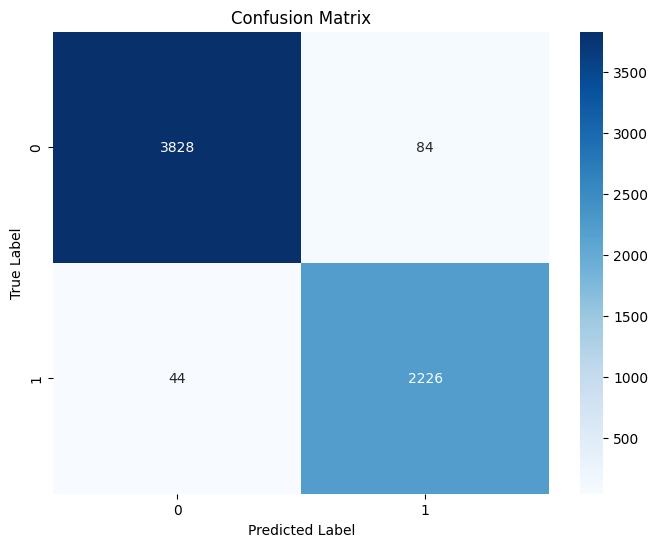

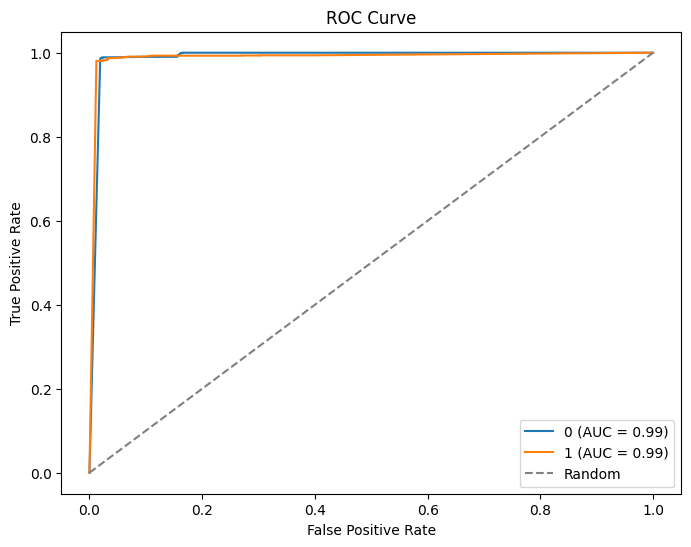

In [12]:
eval(bnb_model,conf_matrix,X_test)

##  Gaussian Naïve Bayes

In [ ]:
gnb_model = GaussianNB()
gnb_model.fit(X_train_1, y_train)
y_pred_word2vec = gnb_model.predict(X_test_1)
joblib.dump(gnb_model, 'models/gnb_model.joblib')


accuracy_word2vec = accuracy_score(y_test, y_pred_word2vec)
conf_matrix = confusion_matrix(y_test, y_pred_word2vec)
classification_rep = classification_report(y_test, y_pred_word2vec)

# Display the results
print(f"Accuracy: {accuracy_word2vec}")
display(HTML("<hr>"))

print("Confusion Matrix:")
print(conf_matrix)
display(HTML("<hr>"))

print("Classification Report:")
print(classification_rep)
display(HTML("<hr>Model saved"))


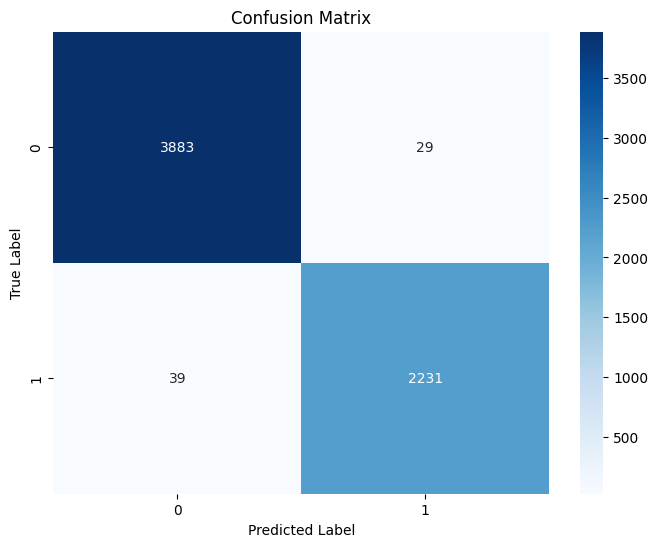

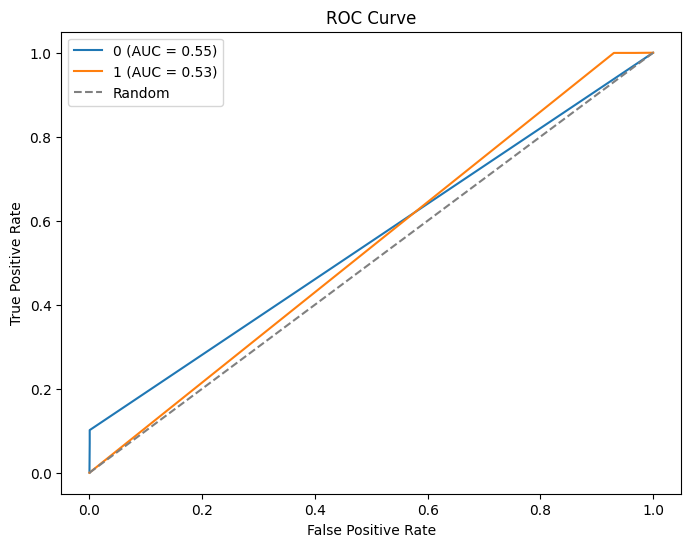

In [14]:
eval(gnb_model,conf_matrix,X_test)

## SVM RBF 

In [15]:
svm_rbf_model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True) 
svm_rbf_model.fit(X_train_1, y_train)

y_pred_svm_rbf = svm_rbf_model.predict(X_test_1)
joblib.dump(svm_rbf_model, 'models/svm_rbf_model.joblib')

accuracy_svm_rbf = accuracy_score(y_test, y_pred_svm_rbf)
conf_matrix_svm_rbf = confusion_matrix(y_test, y_pred_svm_rbf)
classification_rep_svm_rbf = classification_report(y_test, y_pred_svm_rbf)

print(f"Accuracy: {accuracy_svm_rbf}")
display(HTML("<hr>"))

print("Confusion Matrix:")
print(conf_matrix_svm_rbf)
display(HTML("<hr>"))

print("Classification Report:")
print(classification_rep_svm_rbf)
display(HTML("<hr>Model saved"))

Accuracy with SVM RBF: 0.9945001617599483


Confusion Matrix:
[[3909    3]
 [  31 2239]]


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3912
           1       1.00      0.99      0.99      2270

    accuracy                           0.99      6182
   macro avg       1.00      0.99      0.99      6182
weighted avg       0.99      0.99      0.99      6182



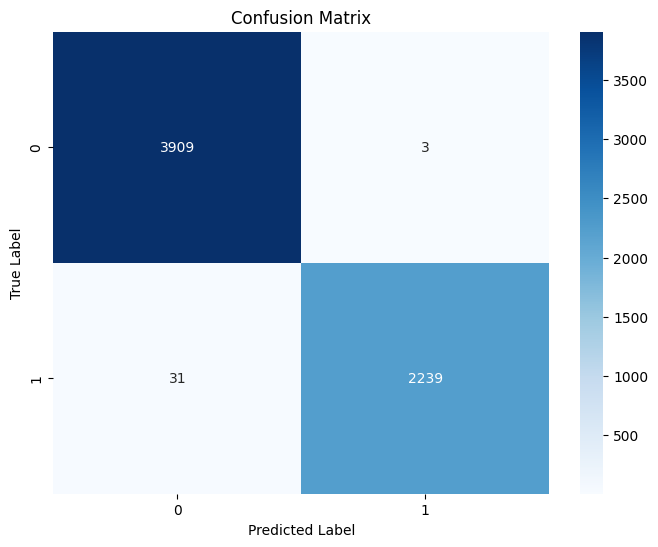

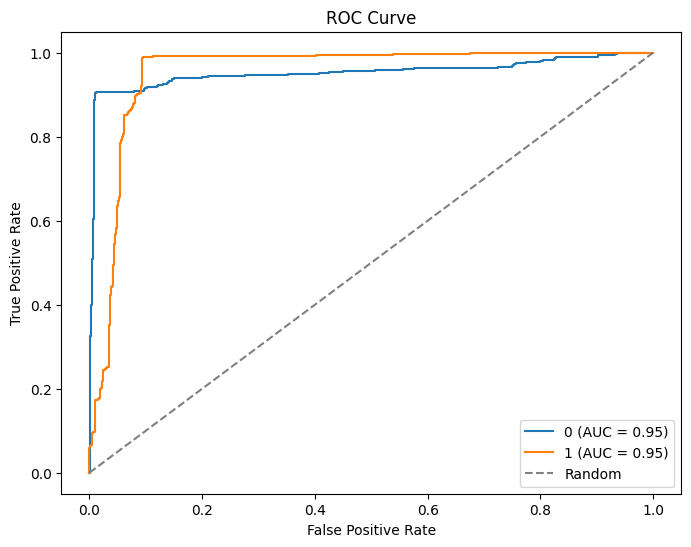

In [16]:
eval(svm_rbf_model,conf_matrix_svm_rbf,X_test)

## Logistic Regression

In [23]:
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train_1, y_train)
joblib.dump(logreg_model, 'models/log_reg_model.joblib')

y_pred_logreg = logreg_model.predict(X_test_1)

accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
conf_matrix_logreg = confusion_matrix(y_test, y_pred_logreg)
classification_rep_logreg = classification_report(y_test, y_pred_logreg)
 
print(f"Accuracy: {accuracy_logreg}")
print("Confusion Matrix:")
print(conf_matrix_logreg)
print("Classification Report:")
print(classification_rep_logreg)

Accuracy with Logistic Regression: 0.9941766418634747
Confusion Matrix:
[[3910    2]
 [  34 2236]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3912
           1       1.00      0.99      0.99      2270

    accuracy                           0.99      6182
   macro avg       1.00      0.99      0.99      6182
weighted avg       0.99      0.99      0.99      6182



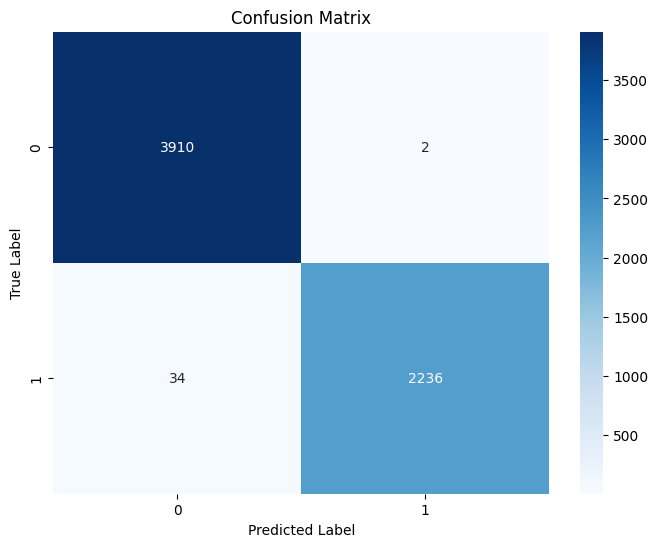

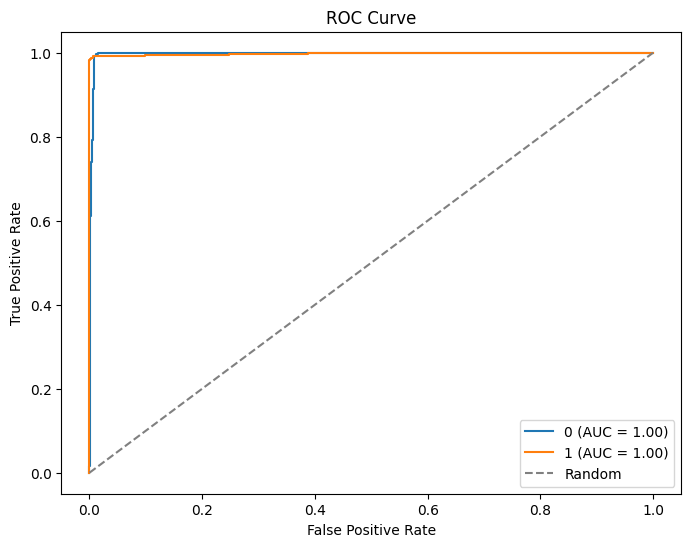

In [18]:
eval(logreg_model,conf_matrix_logreg,X_test_1)


## Decision tree

In [9]:
dt_model = DecisionTreeClassifier(max_depth=None, min_samples_split=5, min_samples_leaf=2, random_state=5)
dt_model.fit(X_train_1, y_train)
joblib.dump(dt_model, 'models/dt_model.joblib')

y_pred_dt = dt_model.predict(X_test_1)

accuracy_dt = accuracy_score(y_test, y_pred_dt)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
classification_rep_dt = classification_report(y_test, y_pred_dt)

print(f"Accuracy with Decision Tree: {accuracy_dt}")
display(HTML("<hr>"))

print("Confusion Matrix:")
print(conf_matrix_dt)
display(HTML("<hr>"))

print("Classification Report:")
print(classification_rep_dt)
display(HTML("<hr>Model saved"))

Accuracy with Decision Tree: 0.9943384018117114


Confusion Matrix:
[[3898   14]
 [  21 2249]]


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3912
           1       0.99      0.99      0.99      2270

    accuracy                           0.99      6182
   macro avg       0.99      0.99      0.99      6182
weighted avg       0.99      0.99      0.99      6182



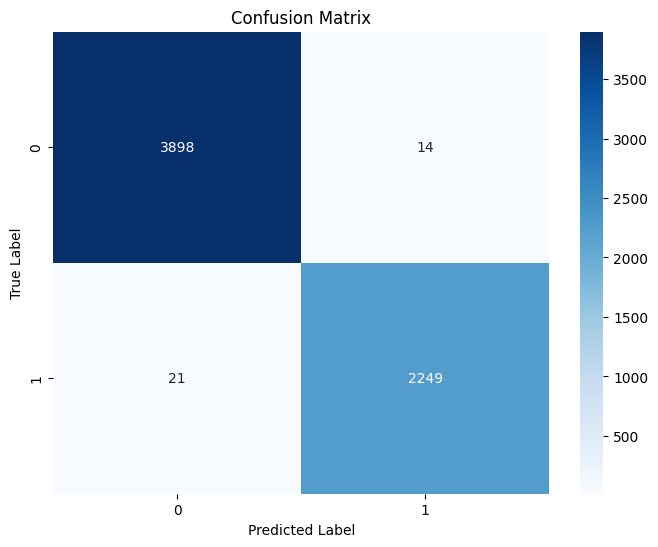

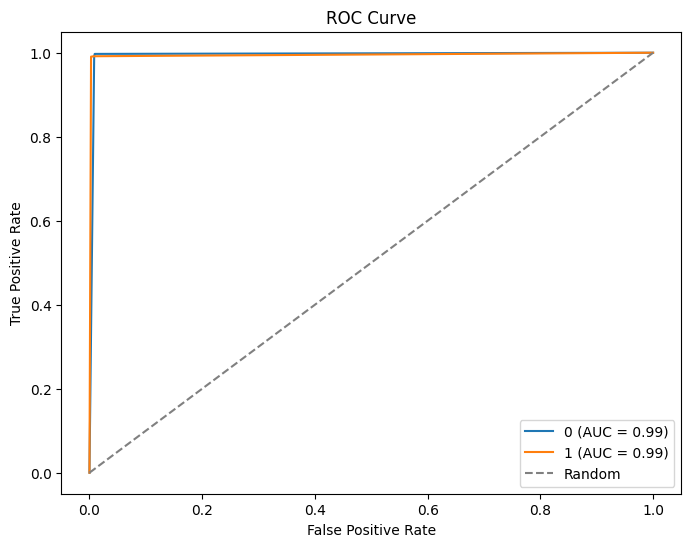

In [10]:
eval(dt_model,conf_matrix_dt,X_test_1)

plt.figure(figsize=(120,400))
tree.plot_tree(dt_model,rounded=True, fontsize=50)
plt.show()



## Random forest

In [21]:
forest_model = RandomForestClassifier(n_estimators=10, random_state=5)
forest_model.fit(X_train_1, y_train)

joblib.dump(forest_model, 'models/forest_model.joblib')

y_pred = dt_model.predict(X_test_1)

accuracy = accuracy_score(y_test, y_pred_dt)
conf_matrix = confusion_matrix(y_test, y_pred_dt)
classification_rep = classification_report(y_test, y_pred_dt)

print(f"Accuracy: {accuracy}")
display(HTML("<hr>"))

print("Confusion Matrix:")
print(conf_matrix)
display(HTML("<hr>"))

print("Classification Report:")
print(classification_rep)
display(HTML("<hr>Model saved"))

Accuracy: 0.9945001617599483


Confusion Matrix:
[[3900   12]
 [  22 2248]]


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3912
           1       0.99      0.99      0.99      2270

    accuracy                           0.99      6182
   macro avg       0.99      0.99      0.99      6182
weighted avg       0.99      0.99      0.99      6182



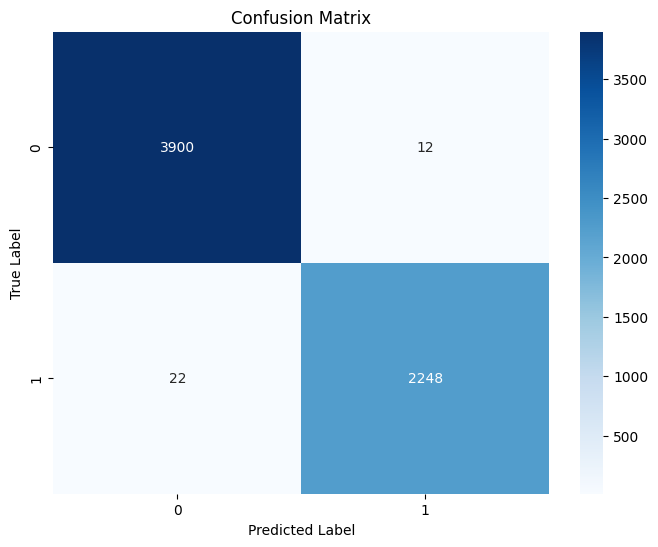

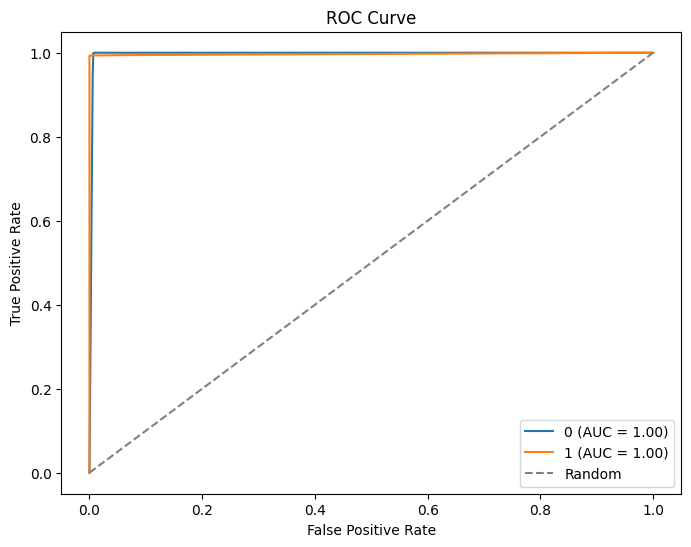

In [22]:
eval(forest_model,conf_matrix,X_test_1)

#fig, axes = plt.subplots((10 + 2) // 3, 3, figsize=(15, 30))
# for i, ax in enumerate(axes.flatten()):
#     if i < 10:
#         tree.plot_tree(forest_model.estimators_[i], rounded=True, filled=True, fontsize=8, ax=ax)

# plt.tight_layout()
# plt.show()

## Neural Networks

In [ ]:


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

### CNN

In [ ]:



cnn_model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(1000, 1)), 
    MaxPooling1D(2), 
    Conv1D(64, 3, activation='relu'), 
    MaxPooling1D(2), 
    Flatten(), 
    Dense(64, activation='relu'), 
    Dense(1, activation='sigmoid') 
])

cnn_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])


cnn_model.fit(X_train_1.reshape((24725, 1000, 1)), np.array(y_train), epochs=5, batch_size=64, verbose=1)

y_pred_cnn = cnn_model.predict(X_test_1.reshape((6182, 1000, 1)))
y_pred_cnn = np.where(y_pred_cnn >= 0.5, 1, 0)

cnn_model.save("models\\cnn_model.keras")

accuracy = accuracy_score(y_test, y_pred_cnn)
conf_matrix = confusion_matrix(y_test, y_pred_cnn)
classification_rep = classification_report(y_test, y_pred_cnn)

print(f"Accuracy: {accuracy}")
display(HTML("<hr>"))

print("Confusion Matrix:")
print(conf_matrix)
display(HTML("<hr>"))

print("Classification Report:")
print(classification_rep)
display(HTML("<hr>Model saved"))



c:\Users\Anirudh Srivathsan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/5
387/387 ━━━━━━━━━━━━━━━━━━━━ 41s 95ms/step - accuracy: 0.9635 - loss: 0.1169
Epoch 2/5
387/387 ━━━━━━━━━━━━━━━━━━━━ 38s 98ms/step - accuracy: 0.9950 - loss: 0.0258
Epoch 3/5
387/387 ━━━━━━━━━━━━━━━━━━━━ 41s 98ms/step - accuracy: 0.9948 - loss: 0.0276
Epoch 4/5
387/387 ━━━━━━━━━━━━━━━━━━━━ 41s 97ms/step - accuracy: 0.9949 - loss: 0.0246
Epoch 5/5
387/387 ━━━━━━━━━━━━━━━━━━━━ 39s 101ms/step - accuracy: 0.9948 - loss: 0.0226
194/194 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step
Accuracy: 0.9954707214493691


Confusion Matrix:
[[3910    2]
 [  26 2244]]


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3912
           1       1.00      0.99      0.99      2270

    accuracy                           1.00      6182
   macro avg       1.00      0.99      1.00      6182
weighted avg       1.00      1.00      1.00      6182



ValueError: No such layer: conv1d. Existing layers are: ['conv1d_2', 'max_pooling1d_2', 'conv1d_3', 'max_pooling1d_3', 'flatten_1', 'dense_2', 'dense_3'].

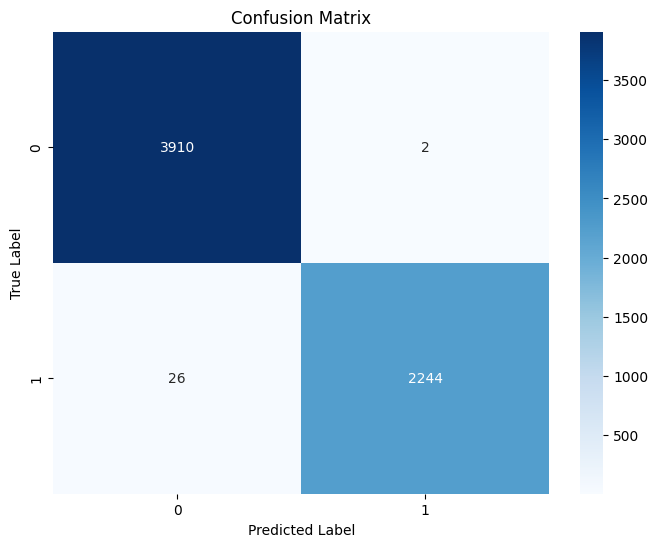

194/194 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step


<Figure size 800x600 with 0 Axes>

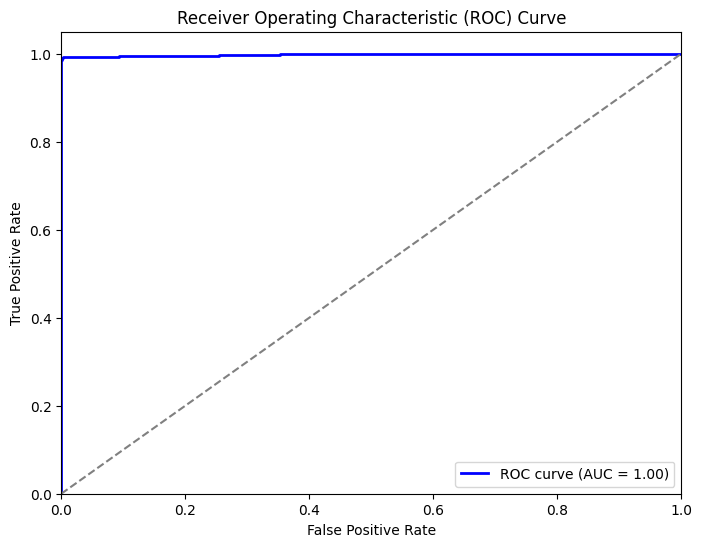

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 998, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 499, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 497, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 248, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 15872)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     1,015,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,066,821 (11.70 MB)

 Trainable params: 1,022,273 (3.90 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,044,548 (7.80 MB)

In [40]:

eval_keras(cnn_model,conf_matrix,X_test_1,y_test)


## ANN

In [41]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

ann_model = Sequential([
    Dense(64, activation='relu', input_shape=(1000,)), 
    Dense(64, activation='relu'), 
    Dense(1, activation='sigmoid') 
])

ann_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

ann_model.fit(X_train_1.reshape((24725, 1000)), np.array(y_train), epochs=5, batch_size=64, verbose=1)

y_pred_ann = ann_model.predict(X_test_1.reshape((6182, 1000)))
y_pred_ann = np.where(y_pred_ann >= 0.5, 1, 0)

ann_model.save("models/ann_model.keras")

accuracy = accuracy_score(y_test, y_pred_ann)
conf_matrix = confusion_matrix(y_test, y_pred_ann)
classification_rep = classification_report(y_test, y_pred_ann)

print(f"Accuracy: {accuracy}")
display(HTML("<hr>"))

print("Confusion Matrix:")
print(conf_matrix)
display(HTML("<hr>"))

print("Classification Report:")
print(classification_rep)
display(HTML("<hr>Model saved"))


c:\Users\Anirudh Srivathsan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
387/387 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9735 - loss: 0.0966
Epoch 2/5
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9929 - loss: 0.0334
Epoch 3/5
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9932 - loss: 0.0325
Epoch 4/5
387/387 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9923 - loss: 0.0350
Epoch 5/5
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9935 - loss: 0.0280
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Accuracy: 0.9933678421222906


Confusion Matrix:
[[3908    4]
 [  37 2233]]


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3912
           1       1.00      0.98      0.99      2270

    accuracy                           0.99      6182
   macro avg       0.99      0.99      0.99      6182
weighted avg       0.99      0.99      0.99      6182



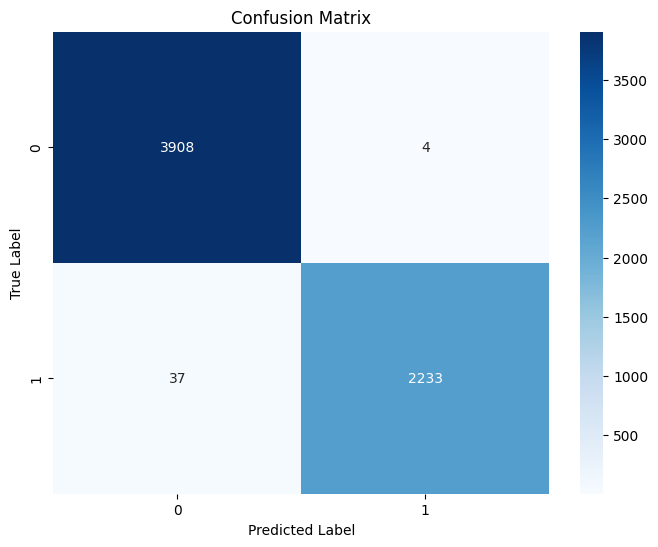

194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


<Figure size 800x600 with 0 Axes>

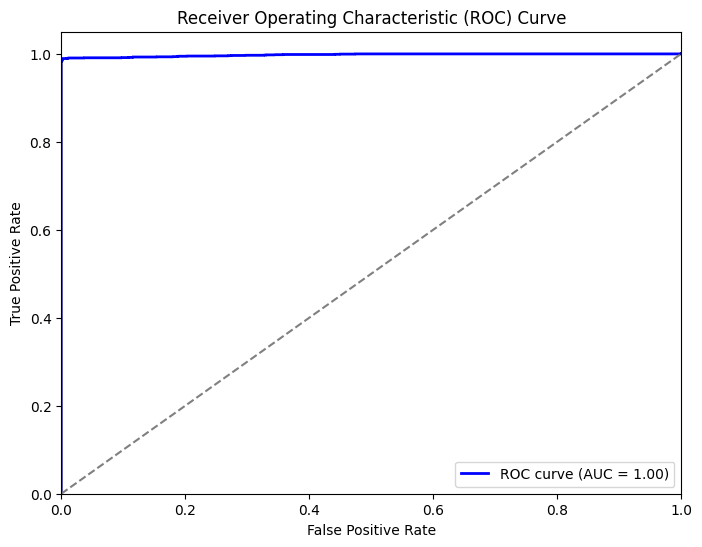

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │        64,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 204,869 (800.27 KB)

 Trainable params: 68,289 (266.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 136,580 (533.52 KB)

In [43]:
eval_keras(ann_model,conf_matrix,X_test_1,y_test)


### RNN

In [44]:
from tensorflow.keras.layers import LSTM, Dense

# Define the RNN model
rnn_model = Sequential([
    LSTM(64, input_shape=(1000, 1)),  # LSTM layer with 64 units
    Dense(1, activation='sigmoid')  # Output layer
])

# Compile the model
rnn_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Train the model
rnn_model.fit(X_train_1.reshape((24725, 1000, 1)), np.array(y_train), epochs=5, batch_size=64, verbose=1)

# Make predictions
y_pred_rnn = rnn_model.predict(X_test_1.reshape((6182, 1000, 1)))
y_pred_rnn = np.where(y_pred_rnn >= 0.5, 1, 0)

# Save the model
rnn_model.save("models/rnn_model.keras")

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_rnn)
conf_matrix = confusion_matrix(y_test, y_pred_rnn)
classification_rep = classification_report(y_test, y_pred_rnn)

print(f"Accuracy: {accuracy}")
display(HTML("<hr>"))

print("Confusion Matrix:")
print(conf_matrix)
display(HTML("<hr>"))

print("Classification Report:")
print(classification_rep)
display(HTML("<hr>Model saved"))

c:\Users\Anirudh Srivathsan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
387/387 ━━━━━━━━━━━━━━━━━━━━ 423s 1s/step - accuracy: 0.6905 - loss: 0.5811
Epoch 2/5
387/387 ━━━━━━━━━━━━━━━━━━━━ 418s 1s/step - accuracy: 0.8529 - loss: 0.4337
Epoch 3/5
387/387 ━━━━━━━━━━━━━━━━━━━━ 418s 1s/step - accuracy: 0.9102 - loss: 0.2657
Epoch 4/5
387/387 ━━━━━━━━━━━━━━━━━━━━ 425s 1s/step - accuracy: 0.9834 - loss: 0.0664
Epoch 5/5
387/387 ━━━━━━━━━━━━━━━━━━━━ 422s 1s/step - accuracy: 0.9690 - loss: 0.0956
194/194 ━━━━━━━━━━━━━━━━━━━━ 65s 334ms/step
Accuracy: 0.9860886444516338


Confusion Matrix:
[[3865   47]
 [  39 2231]]


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3912
           1       0.98      0.98      0.98      2270

    accuracy                           0.99      6182
   macro avg       0.98      0.99      0.99      6182
weighted avg       0.99      0.99      0.99      6182



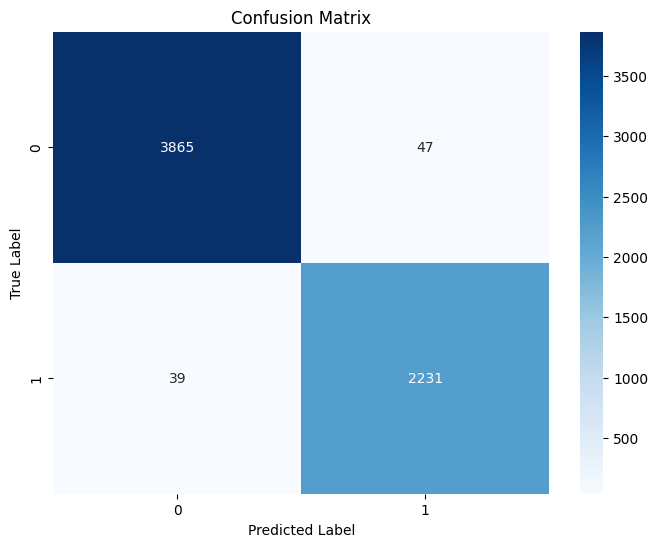

ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None

In [45]:
eval_keras(rnn_model,conf_matrix,X_test_1,y_test)
